In [103]:
import regex as re
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [104]:
prob_ad_dir = '../train/transcription/cd/*'
controls_dir = '../train/transcription/cc/*'

In [105]:
def extract_data(file_name):
    par = {}
    par['id'] = file_name.split('/')[-1].split('.cha')[0]
    f = iter(open(file_name))
    l = next(f)
    speech = []
    try:
        curr_speech = ''
        while (True):
            if l.startswith('*PAR:') or l.startswith('*INV'):
                curr_speech = l
            elif len(curr_speech) != 0 and not(l.startswith('%') or l.startswith('*')):
                curr_speech += l
            elif len(curr_speech) > 0:
                speech.append(curr_speech)
                curr_speech = ''
            l = next(f)
    except StopIteration:
        pass

    clean_par_speech = []
    clean_all_speech = []
    is_par = False
    for s in speech:
        
        def _clean(s):
            s = re.sub('\x15\d*_\d*\x15', '', s) # remove time block 
            s = re.sub('\[.*\]', '', s) # remove other speech artifacts [.*]
            s = s.strip()
            s = re.sub('\t|\n|<|>', '', s) # remove tab, new lines,ampersand
            return s
        
        if s.startswith('*PAR:'):
            is_par = True
        elif s.startswith('*INV:'):
            is_par = False
            s = re.sub('\*INV:\t', '', s) # remove prefix
        if is_par:
            s = re.sub('\*PAR:\t', '', s) # remove prefix    
            clean_par_speech.append(_clean(s))
        clean_all_speech.append(_clean(s))
        
    par['speech'] = speech
    par['clean_speech'] = clean_all_speech
    par['clean_par_speech'] = clean_par_speech
    par['joined_all_speech'] = ' '.join(clean_all_speech)
    par['joined_all_par_speech'] = ' '.join(clean_par_speech)
    
    return par

In [106]:
def parse_train_data():
    return _parse_data('../data/train')

def _parse_data(data_dir):
    prob_ad_dir = f'{data_dir}/transcription/cd/*'
    controls_dir = f'{data_dir}/transcription/cc/*'
    
    prob_ad = [extract_data(fn) for fn in glob(prob_ad_dir)]
    controls = [extract_data(fn) for fn in glob(controls_dir)]
    controls_df = pd.DataFrame(controls)
    prob_ad_df = pd.DataFrame(prob_ad)
    controls_df['ad'] = 0
    prob_ad_df['ad'] = 1
    df = pd.concat([controls_df, prob_ad_df]).sample(frac=1).reset_index(drop=True)
    return df

In [107]:
train_df = parse_train_data()

In [108]:
random_state = 10

In [109]:
def randomforst_models(text: pd.Series, labels: list, shuffle=True):
    ## AD Classification Pred
    
    # sklearn pipeline
    param_space = {
        'vec__max_features': [100, 500, 1000, 2000, 10000],
        'vec__stop_words': ['english', None],
        'vec__analyzer': ['word', 'char'],
        'vec__max_df': [0.5, 0.75, 1.0],
        'vec__sublinear_tf': [True, False]    
     
    }    
    param_space['clf__n_estimators'] = 10,  
    param_space['clf__max_depth'] = 10,  
    param_space['clf__min_samples_split']= 5,
    param_space['clf__min_samples_leaf']= 2,
    param_space ['clf__bootstrap']= [True, False]

    clf_pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('clf', RandomForestClassifier())
    ])
    train_features, test_features, train_labels, test_labels = train_test_split(text, labels, random_state=random_state, test_size=0.2, shuffle=shuffle)
    search = GridSearchCV(clf_pipe, param_space, cv=10, n_jobs=6)
    search.fit(train_features, train_labels)
    clf_pipe.set_params(**search.best_params_)
    print(search.best_params_)
    clf_pipe.fit(train_features, train_labels)
    return clf_pipe, test_features,test_labels,train_features,train_labels

In [110]:
clf_ran,test_features,test_labels,train_features,train_labels = randomforst_models(train_df.joined_all_speech, train_df.ad)

{'clf__bootstrap': False, 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 10, 'vec__analyzer': 'word', 'vec__max_df': 0.5, 'vec__max_features': 2000, 'vec__stop_words': None, 'vec__sublinear_tf': True}


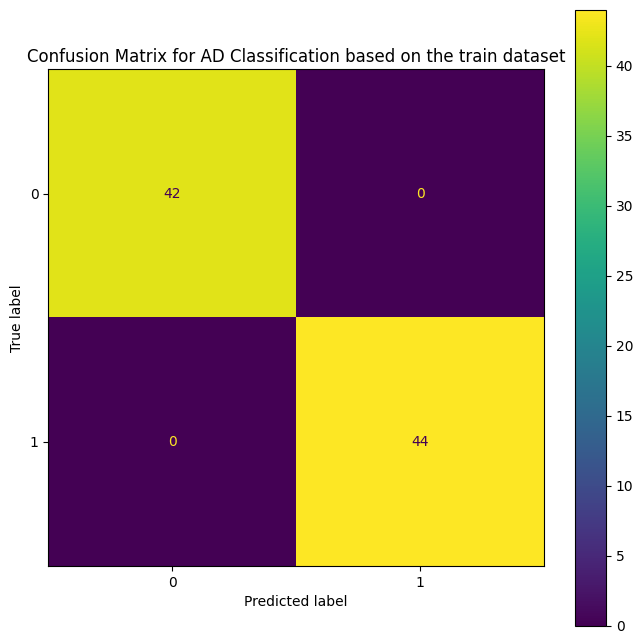

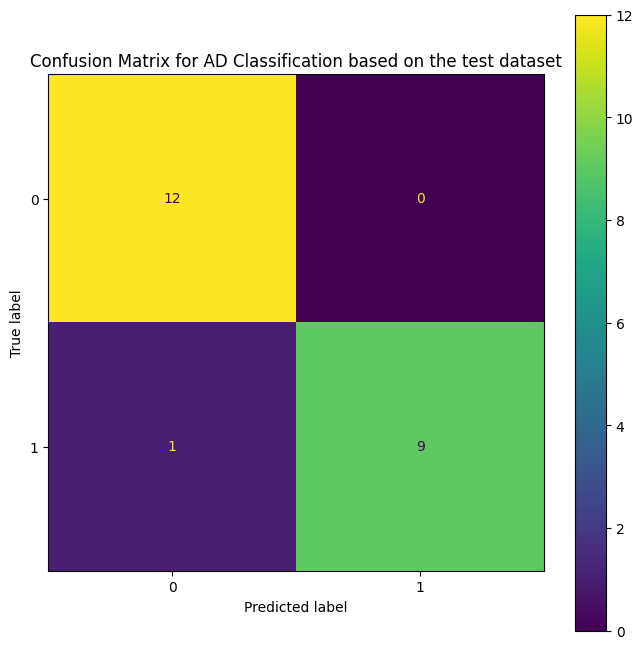

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# # confusion matrix for AD classification
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf_ran, train_features, train_labels, ax=ax)
ax.set_title('Confusion Matrix for AD Classification based on the train dataset')
plt.savefig('train_cm.png')
# confusion matrix for AD classification
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf_ran, test_features, test_labels, ax=ax)
ax.set_title('Confusion Matrix for AD Classification based on the test dataset')
plt.savefig('test_cm.png')

In [101]:
clf_ran_par,test_features,test_labels,train_features,train_labels = randomforst_models(train_df.joined_all_par_speech, train_df.ad)

{'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 10, 'vec__analyzer': 'word', 'vec__max_df': 0.5, 'vec__max_features': 2000, 'vec__stop_words': 'english', 'vec__sublinear_tf': True}


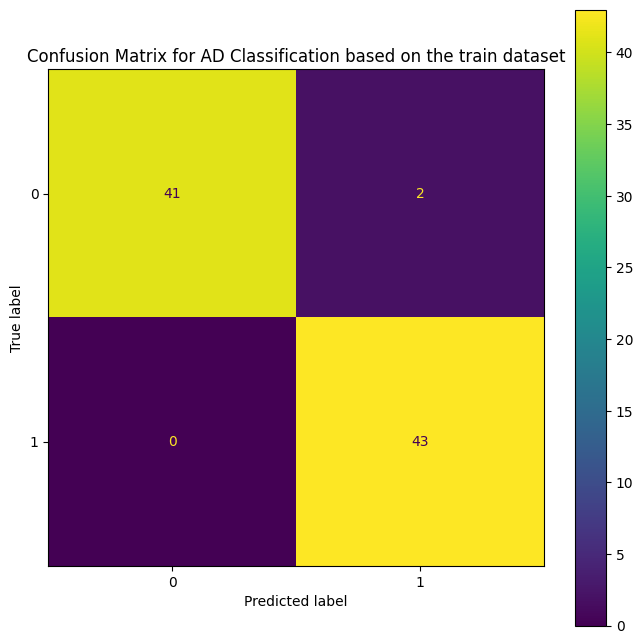

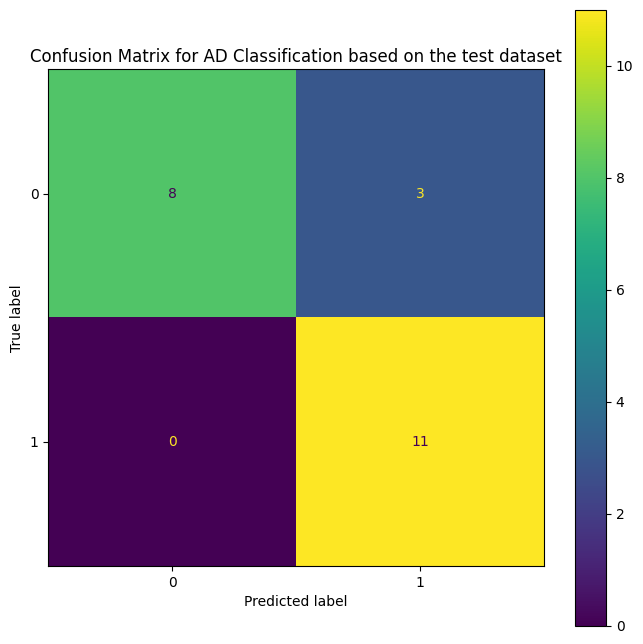

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# # confusion matrix for AD classification
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf_ran_par, train_features, train_labels, ax=ax)
ax.set_title('Confusion Matrix for AD Classification based on the train dataset')
plt.savefig('train_cm.png')
# confusion matrix for AD classification
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf_ran_par, test_features, test_labels, ax=ax)
ax.set_title('Confusion Matrix for AD Classification based on the test dataset')
plt.savefig('test_cm.png')